In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import os
import pickle
import random
import sys

# import ivac
import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np
import scipy
import seaborn as sns
from matplotlib import ticker
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors

import extq
import prettypyplot as pplt

In [3]:
! source /project/dinner/scguo/upside2/sourceme.sh

In [4]:
# upside_path = os.environ["UPSIDE_HOME"]
upside_path = "/project/dinner/scguo/upside2/"
upside_utils_dir = os.path.expanduser(upside_path + "/py")
sys.path.insert(0, upside_utils_dir)

In [5]:
plt.style.use("custom")  # custom style sheet
plt.style.use("vibrant")  # muted color theme from SciencePlots
pplt.load_cmaps()

In [6]:
plt.rcParams[
    "text.latex.preamble"
] = r"\usepackage{siunitx}\sisetup{detect-all}\usepackage{helvet}\usepackage{sansmath}\sansmath"
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = "cm"

# Load data

In [7]:
home_dir = "/project/dinner/scguo/kaiB"
base_dir = "/project/dinner/scguo/kaiB/dga/87"

In [8]:
def load_cvs(base_dir, n_s, n_i):
    raw_feats, fs_qtots, f_rmsds, p_rmsds, r_rmsds, dssps, omegas = [], [], [], [], [], [], []
    for i in range(n_s):
        for j in range(n_i):
            for iso in ("cis", "trans"):
                idx = f"{i:02}_{j:02}_{iso}"
                head = f"{idx}_dga"
                if not os.path.exists(f"{base_dir}/{idx}/outputs/{head}_raw_feats.pkl"):
                    continue
                raw_feats.extend(
                    np.load(f"{base_dir}/{idx}/outputs/{head}_raw_feats.pkl", allow_pickle=True)
                )
                fs_qtots.extend(np.load(f"{base_dir}/{idx}/outputs/{head}_fs_qtots.pkl", allow_pickle=True))
                f_rmsds.extend(np.load(f"{base_dir}/{idx}/outputs/{head}_f_rmsds.pkl", allow_pickle=True))
                p_rmsds.extend(np.load(f"{base_dir}/{idx}/outputs/{head}_p_rmsds.pkl", allow_pickle=True))
                r_rmsds.extend(np.load(f"{base_dir}/{idx}/outputs/{head}_r_rmsds.pkl", allow_pickle=True))
                for k in range(2):
                    if not os.path.exists(f"{base_dir}/{idx}/outputs/{idx}_{k:02}_Omega.npy"):
                        continue
                    omegas.append(np.load(f"{base_dir}/{idx}/outputs/{idx}_{k:02}_Omega.npy"))
                    dssps.append(np.load(f"{base_dir}/{idx}/outputs/{idx}_{k:02}_dssp.npy"))
    return raw_feats, fs_qtots, f_rmsds, p_rmsds, r_rmsds, omegas, dssps

In [9]:
raw_feats, fs_qtots, f_rmsds, p_rmsds, r_rmsds, omegas, dssps = load_cvs(base_dir, 7, 32)

In [10]:
n_cis, p63_cis, p70_cis, p71_cis, p72_cis = [], [], [], [], []
for omega in omegas:
    n_cis.append(np.sum((np.abs(omega[:, 3:]) <= (np.pi / 2.0)).astype(int), axis=1))
    p63_cis.append((np.abs(omega[:, 3]) <= (np.pi / 2.0)).astype(bool))
    p70_cis.append((np.abs(omega[:, 4]) <= (np.pi / 2.0)).astype(bool))
    p71_cis.append((np.abs(omega[:, 5]) <= (np.pi / 2.0)).astype(bool))
    p72_cis.append((np.abs(omega[:, 6]) <= (np.pi / 2.0)).astype(bool))

In [11]:
print(len(raw_feats), raw_feats[0].shape)

896 (39997, 325)


In [12]:
# Adam's CVs
c_gsa1 = np.concatenate([traj[1, :] for traj in fs_qtots])
c_gsa2 = np.concatenate([traj[3, :] for traj in fs_qtots])
c_gsb2 = np.concatenate([traj[5, :] for traj in fs_qtots])

c_fsb1 = np.concatenate([traj[0, :] for traj in fs_qtots])
c_fsb2 = np.concatenate([traj[2, :] for traj in fs_qtots])
c_fsa2 = np.concatenate([traj[4, :] for traj in fs_qtots])

c_green_arr = c_gsa2 - c_fsb2
c_blue_arr = c_gsb2 - c_fsa2
c_orange_arr = c_gsa1 - c_fsb1

c_green = [traj[3, :] - traj[2, :] for traj in fs_qtots]
c_blue = [traj[5, :] - traj[4, :] for traj in fs_qtots]
c_orange = [traj[1, :] - traj[0, :] for traj in fs_qtots]

In [13]:
p_rmsd_arr = np.asarray(p_rmsds).ravel()
f_rmsd_arr = np.asarray(f_rmsds).ravel()
in_fs = np.logical_and(
    c_green_arr < -0.78,
    np.logical_and(c_blue_arr < -0.83, np.logical_and(c_orange_arr < -0.75, f_rmsd_arr < 0.35)),
)

in_gs = np.logical_and(
    c_green_arr > 0.67,
    np.logical_and(c_blue_arr > 0.88, np.logical_and(c_orange_arr > 0.75, p_rmsd_arr < 0.45)),
)

# IVAC

In [13]:
# np.save(f"{base_dir}/dga_data/ivac_10d_10-1000.npy", ivac_trajs)
ivac_trajs = np.load(f"{base_dir}/dga_data/ivac_10d_10-1000.npy")

# $k$-means

In [14]:
dtraj = np.load(f"{base_dir}/dga_data/dtraj_300.npy")

# Utility functions

In [14]:
def split_indices(arrays):
    """Gets the indices for np.split from a
    list of arrays.

    Parameters
    ----------
    arrays : ndarray or list/tuple of ndarray
        Arrays from which to get indices

    Returns
    -------
    traj_inds : list of int
        Frame separators to use in np.split
    """
    traj_lens = [len(traj) for traj in arrays]
    traj_inds = []
    subtot = 0
    for length in traj_lens[:-1]:
        subtot += length
        traj_inds.append(subtot)
    return traj_inds

In [15]:
traj_inds = split_indices(raw_feats)

# Indicator basis and guess functions

In [105]:
def make_sparse_basis(dtrajs):
    """Converts a discretized trajectory (e.g. from k-means clustering)
    into a sparse basis of indicator functions.

    Parameters
    ----------
    dtrajs : ndarray
        discretized trajectories

    Return
    ------
    basis : scipy.sparse.csr_matrix
    """
    nclusters = len(np.unique(dtrajs))
    rows, cols = [], []
    for i in range(nclusters):
        pts = np.argwhere(dtrajs == i)
        # indices of which frames are in the cluster i
        rows.append(pts.squeeze())
        # all assigned as 1 in the basis
        cols.append(np.repeat(i, len(pts)))
    rows = np.hstack(rows)
    cols = np.hstack(cols)
    data = np.ones(len(rows), dtype=float)
    basis = scipy.sparse.csr_matrix((data, (rows, cols)), shape=(len(dtrajs), nclusters))
    return basis

In [18]:
# split into lists of arrays
basis_arr = make_sparse_basis(np.squeeze(dtraj))
basis_d_arr = basis_arr.copy()
basis_d_arr[in_fs] = 0
basis_d_arr[in_gs] = 0

traj_lens = [len(traj) for traj in raw_feats]
basis, basis_d = [], []
curr = 0
for t_len in traj_lens:
    basis.append(basis_arr[curr : curr + t_len, :-1])
    basis_d.append(basis_d_arr[curr : curr + t_len])
    curr += t_len

traj_inds = split_indices(raw_feats)
guess_fs = np.split(in_fs.astype(float), traj_inds)
guess_gs = np.split(in_gs.astype(float), traj_inds)

print(len(basis), basis[0].shape)

/beagle3/dinner/scguo/envs/md/lib/python3.11/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


896 (39997, 299)


# Weights, PMF, eq averages, committors

In [17]:
# saved every 50 time steps
lags = np.array([100, 200, 500, 1000, 2000, 5000], dtype=int)
lagtimes = lags * 50

In [26]:
# weights = np.load(f"{base_dir}/dga_data/weights.npy", allow_pickle=True)
weights = {}
mems = [1, 3, 4]
for lag in lags:
    for mem in mems:
        w = extq.memory.reweight(basis, extq.utils.uniform_weights(basis, lag), lag, mem)
        weights[(lag, mem)] = w

In [ ]:
weights[(2000, 3)][0][:100]

/scratch/local/jobs/10506052/ipykernel_74351/4008697737.py:21: RuntimeWarning: divide by zero encountered in log
  offset = np.min(-np.log(hist))
/scratch/local/jobs/10506052/ipykernel_74351/4008697737.py:22: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(hist) - offset
/scratch/local/jobs/10506052/ipykernel_74351/4008697737.py:21: RuntimeWarning: invalid value encountered in log
  offset = np.min(-np.log(hist))
/scratch/local/jobs/10506052/ipykernel_74351/4008697737.py:22: RuntimeWarning: invalid value encountered in log
  pmf = -np.log(hist) - offset
/beagle3/dinner/scguo/envs/md/lib/python3.11/site-packages/matplotlib/contour.py:1454: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/beagle3/dinner/scguo/envs/md/lib/python3.11/site-packages/matplotlib/contour.py:1455: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


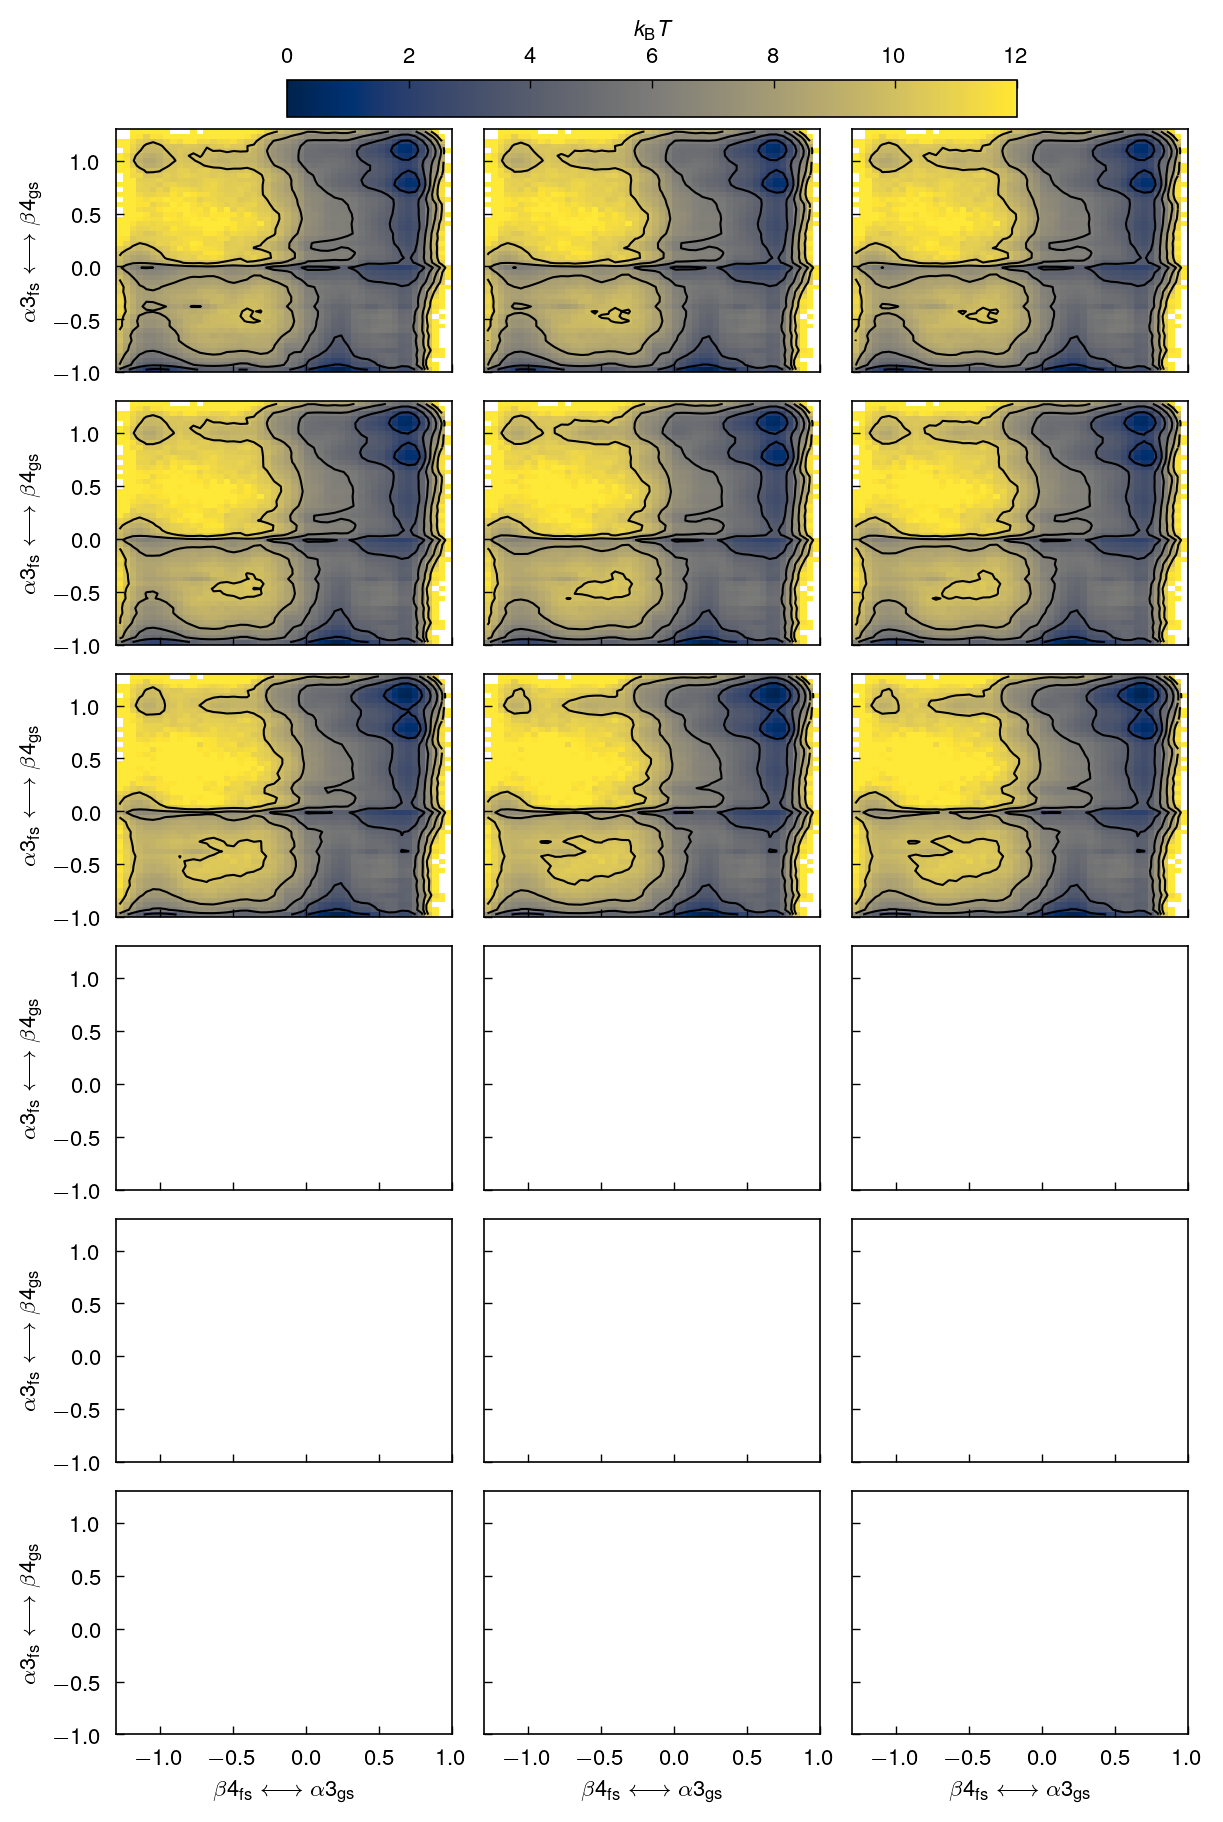

In [30]:
# plot against "GT" and "BT"
fig, axes = plt.subplots(
    nrows=6, ncols=3, figsize=(6, 9), dpi=200, sharex=True, sharey=True, constrained_layout=True
)

xe = np.linspace(-1.3, 1, 51)
ye = np.linspace(-1, 1.3, 51)
xc = (xe[1:] + xe[:-1]) / 2
yc = (ye[1:] + ye[:-1]) / 2
clines = np.arange(0, 12, 2)

for i in range(6):
    lag = lags[i]
    for j in range(3):
        ax = axes[i, j]
        w = weights[(lag, mems[j])]
        w_delay = [t[:-lag] for t in w]
        cv1_delay = [t[lag:] for t in c_green]
        cv2_delay = [t[lag:] for t in c_blue]
        hist = extq.projection.density2d(cv1_delay, cv2_delay, w_delay, xe, ye)
        offset = np.min(-np.log(hist))
        pmf = -np.log(hist) - offset
        pc = ax.pcolormesh(xc, yc, pmf.T, cmap="cividis", vmax=12)
        ax.contour(xc, yc, pmf.T, colors="black", levels=clines)
        ax.set_ylabel(r"$\alpha3_{\mathrm{fs}}\longleftrightarrow \beta4_{\mathrm{gs}}$")
        ax.set_xlabel(r"$\beta4_{\mathrm{fs}}\longleftrightarrow\alpha3_{\mathrm{gs}}$")
        ax.label_outer()
cb = plt.colorbar(pc, ax=axes[0, :], location="top", label=r"$k_{\mathrm{B}}T$")

In [18]:
weights = np.load(f"{base_dir}/dga_data/weights.npy")
print(weights.shape)

(6, 896, 39997)


In [19]:
in_domain = ~(in_fs | in_gs)
in_d = np.split(in_domain, traj_inds)

## Compute committors with memorY

In [20]:
def adjust_forward_committor(forward_q, in_domain, lag):
    result_qp = []
    for qp, d in zip(forward_q, in_domain):
        n = len(d)
        assert len(qp) == n
        tp = extq.stop.forward_stop(d)
        iy = np.minimum(np.arange(lag, n), tp[:-lag])
        result_qp.append(qp[iy])
    return result_qp

In [22]:
# weights = np.load(f"{base_dir}/dga_data/weights.npy", allow_pickle=True)
qp_gs2fs, qp_fs2gs = {}, {}
mems = [1, 3, 4]
for lag, w in zip(lags, weights):
    for mem in mems:
        print(f"Computing committors with lag {lag} and mem {mem}")
        gs2fs = extq.memory.forward_committor(basis_d, w, in_d, guess_gs, lag, mem)
        qp_gs2fs[(lag, mem)] = gs2fs
        fs2gs = extq.memory.forward_committor(basis_d, w, in_d, guess_fs, lag, mem)
        qp_fs2gs[(lag, mem)] = fs2gs

Computing committors with lag 100 and mem 1
Computing committors with lag 100 and mem 3
Computing committors with lag 100 and mem 4
Computing committors with lag 200 and mem 1
Computing committors with lag 200 and mem 3
Computing committors with lag 200 and mem 4
Computing committors with lag 500 and mem 1
Computing committors with lag 500 and mem 3
Computing committors with lag 500 and mem 4
Computing committors with lag 1000 and mem 1
Computing committors with lag 1000 and mem 3
Computing committors with lag 1000 and mem 4
Computing committors with lag 2000 and mem 1
Computing committors with lag 2000 and mem 3
Computing committors with lag 2000 and mem 4
Computing committors with lag 5000 and mem 1
Computing committors with lag 5000 and mem 3
Computing committors with lag 5000 and mem 4


In [28]:
qp_gs2fs[(100, 1)][0]

(39997,)

/project/dinner/scguo/extq/src/extq/projection.py:145: RuntimeWarning: invalid value encountered in divide
  return numer / denom


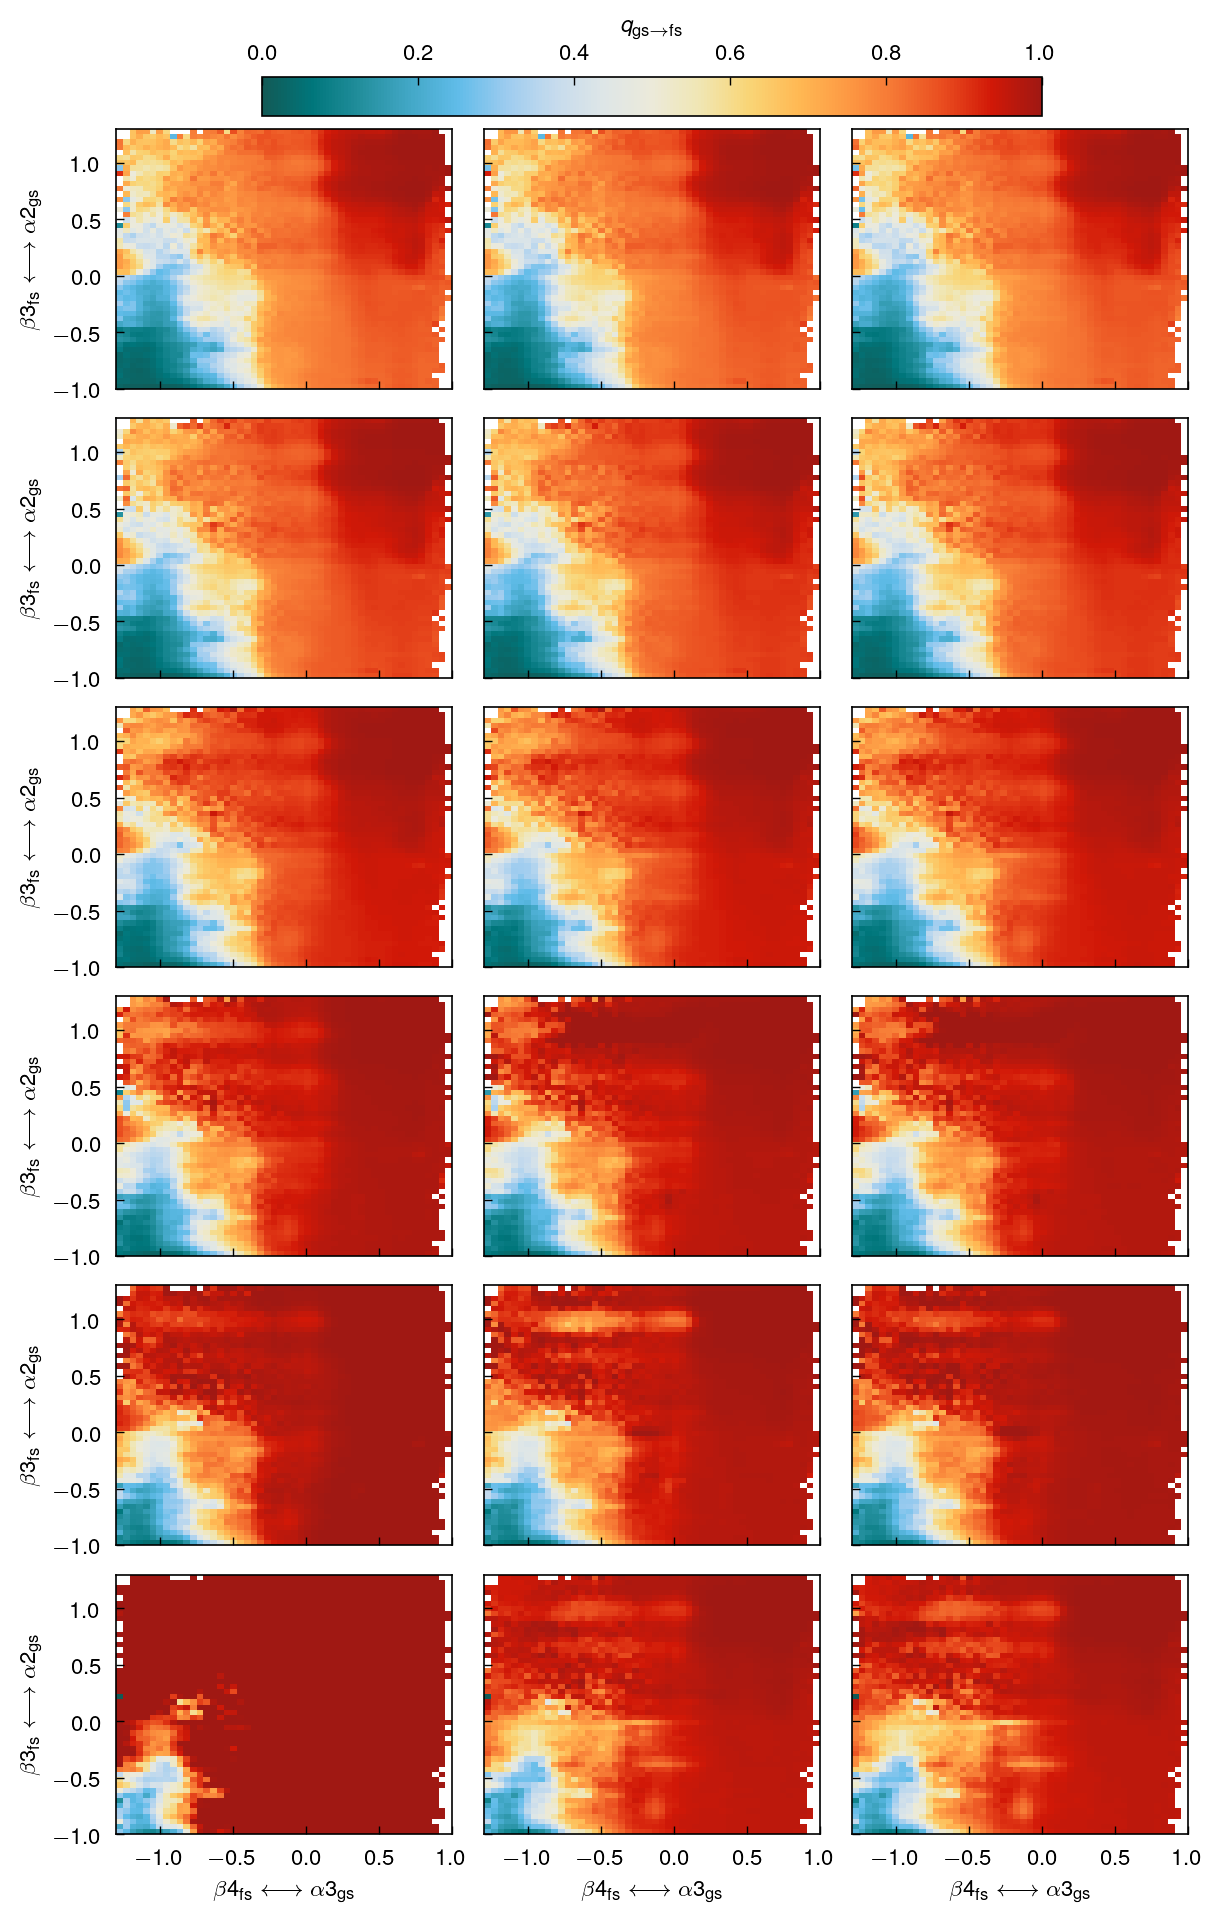

In [30]:
# plot against "GT" and "BT"
fig, axes = plt.subplots(
    nrows=6, ncols=3, figsize=(6, 9.5), dpi=200, sharex=True, sharey=True, constrained_layout=True
)

xe = np.linspace(-1.3, 1, 51)
ye = np.linspace(-1, 1.3, 51)
xc = (xe[1:] + xe[:-1]) / 2
yc = (ye[1:] + ye[:-1]) / 2
clines = np.arange(0, 12, 2)

for i in range(6):
    lag = lags[i]
    w = weights[i]
    # w_delay = [t[:-lag] for t in w]
    # cv1_delay = [t[:-lag] for t in c_green]
    # cv2_delay = [t[:-lag] for t in c_blue]
    for j in range(3):
        ax = axes[i, j]
        q = qp_gs2fs[(lag, mems[j])]
        # qp_delay = adjust_forward_committor(q, in_d, lag)

        # hist = extq.projection.average2d(cv1_delay, cv2_delay, qp_delay, w_delay, xe, ye)
        hist = extq.projection.average2d(c_green, c_blue, q, w, xe, ye)
        pc = ax.pcolormesh(xc, yc, hist.T, cmap="nightfall", vmin=0, vmax=1)
        # ax.contour(xc, yc, hist.T, colors="black", levels=clines)
        ax.set_xlabel(r"$\beta4_{\mathrm{fs}}\longleftrightarrow\alpha3_{\mathrm{gs}}$")
        ax.set_ylabel(
            r"$\beta3_{\mathrm{fs}}\longleftrightarrow\alpha2_{\mathrm{gs}}$",
        )
        ax.label_outer()
cb = plt.colorbar(pc, ax=axes[0, :], location="top", label=r"$q_{\mathrm{gs}\rightarrow\mathrm{fs}}$")

In [34]:
np.save(
    f"{base_dir}/dga_data/qp_gs2fs_lag2000_mem4.npy", qp_fs2gs[(2000, 4)]
)  # accidentally flipped the labels
np.save(f"{base_dir}/dga_data/qp_gs2fs_lag1000_mem4.npy", qp_fs2gs[(1000, 4)])
np.save(f"{base_dir}/dga_data/qp_fs2gs_lag2000_mem4.npy", qp_gs2fs[(2000, 4)])
np.save(f"{base_dir}/dga_data/qp_fs2gs_lag1000_mem4.npy", qp_gs2fs[(1000, 4)])

In [22]:
qp_fs2gs = np.load(f"{base_dir}/dga_data/qp_fs2gs_lag1000_mem4.npy", allow_pickle=True)
qp_gs2fs = np.load(f"{base_dir}/dga_data/qp_gs2fs_lag1000_mem4.npy", allow_pickle=True)

In [21]:
# qp_fs2gs = np.load(f"{base_dir}/dga_data/qp_fs2gs.npy", allow_pickle=True)
# qp_gs2fs = np.load(f"{base_dir}/dga_data/qp_gs2fs.npy", allow_pickle=True)
# qm_fs2gs = np.load(f"{base_dir}/dga_data/qm_fs2gs.npy", allow_pickle=True)
# qm_gs2fs = np.load(f"{base_dir}/dga_data/qm_gs2fs.npy", allow_pickle=True)

## PLots

/project/dinner/scguo/extq/src/extq/projection.py:145: RuntimeWarning: invalid value encountered in divide
  return numer / denom


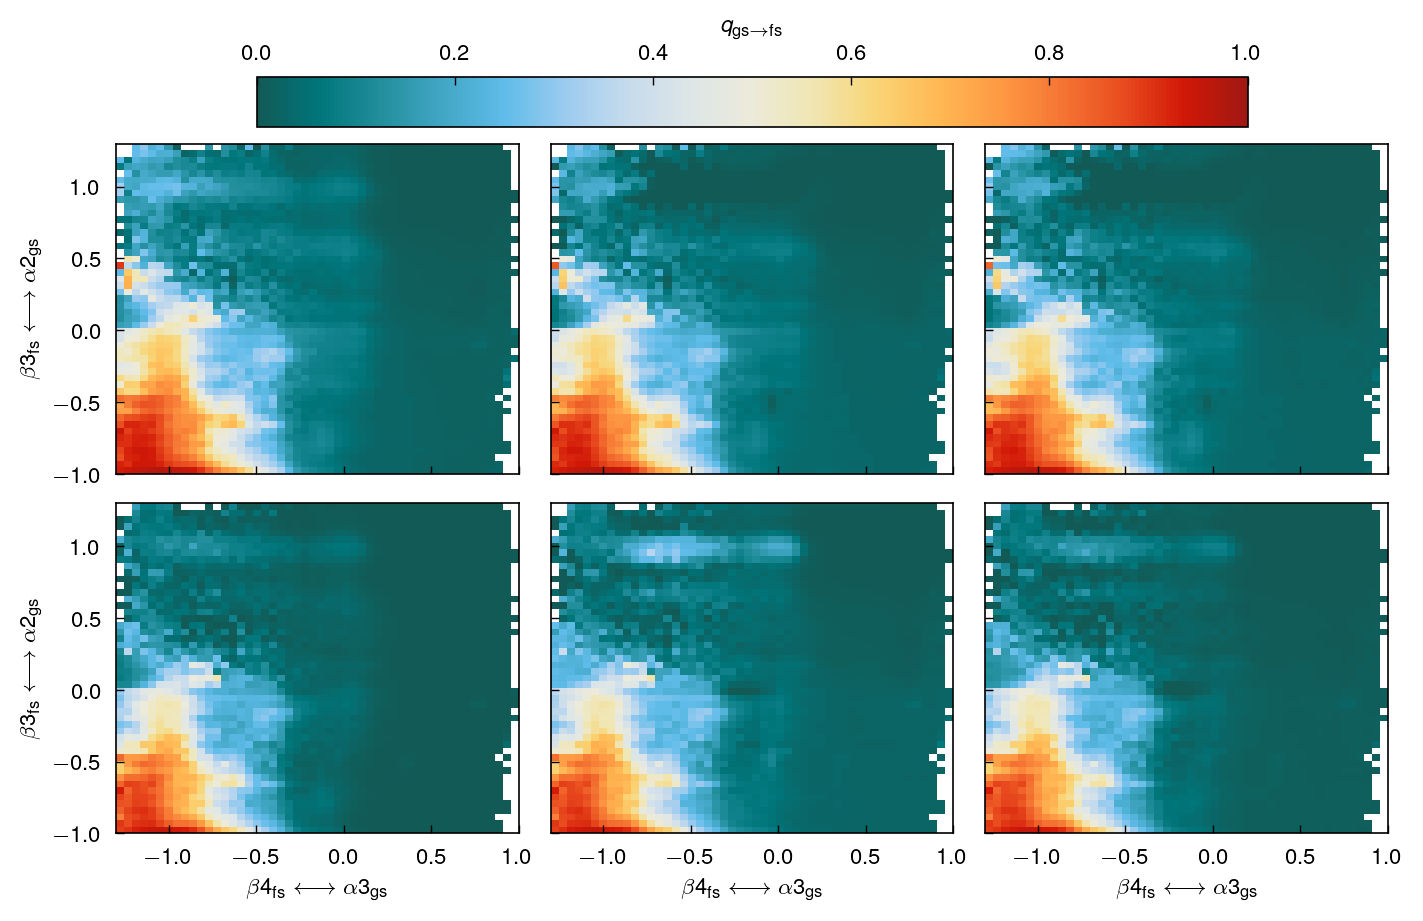

In [31]:
# plot against "GT" and "BT"
fig, axes = plt.subplots(
    nrows=2, ncols=3, figsize=(7, 4.5), dpi=200, sharex=True, sharey=True, constrained_layout=True
)

xe = np.linspace(-1.3, 1, 51)
ye = np.linspace(-1, 1.3, 51)
xc = (xe[1:] + xe[:-1]) / 2
yc = (ye[1:] + ye[:-1]) / 2
clines = np.arange(0, 12, 2)

for i in range(2):
    lag = lags[i + 3]
    w = weights[i + 3]
    for j in range(3):
        ax = axes[i, j]
        q = qp_fs2gs[(lag, mems[j])]
        hist = extq.projection.average2d(c_green, c_blue, q, w, xe, ye)
        pc = ax.pcolormesh(xc, yc, hist.T, cmap="nightfall", vmin=0, vmax=1)
        # ax.contour(xc, yc, hist.T, colors="black", levels=clines)
        ax.set_xlabel(r"$\beta4_{\mathrm{fs}}\longleftrightarrow\alpha3_{\mathrm{gs}}$")
        ax.set_ylabel(
            r"$\beta3_{\mathrm{fs}}\longleftrightarrow\alpha2_{\mathrm{gs}}$",
        )
        ax.label_outer()
cb = plt.colorbar(pc, ax=axes[0, :], location="top", label=r"$q_{\mathrm{gs}\rightarrow\mathrm{fs}}$")

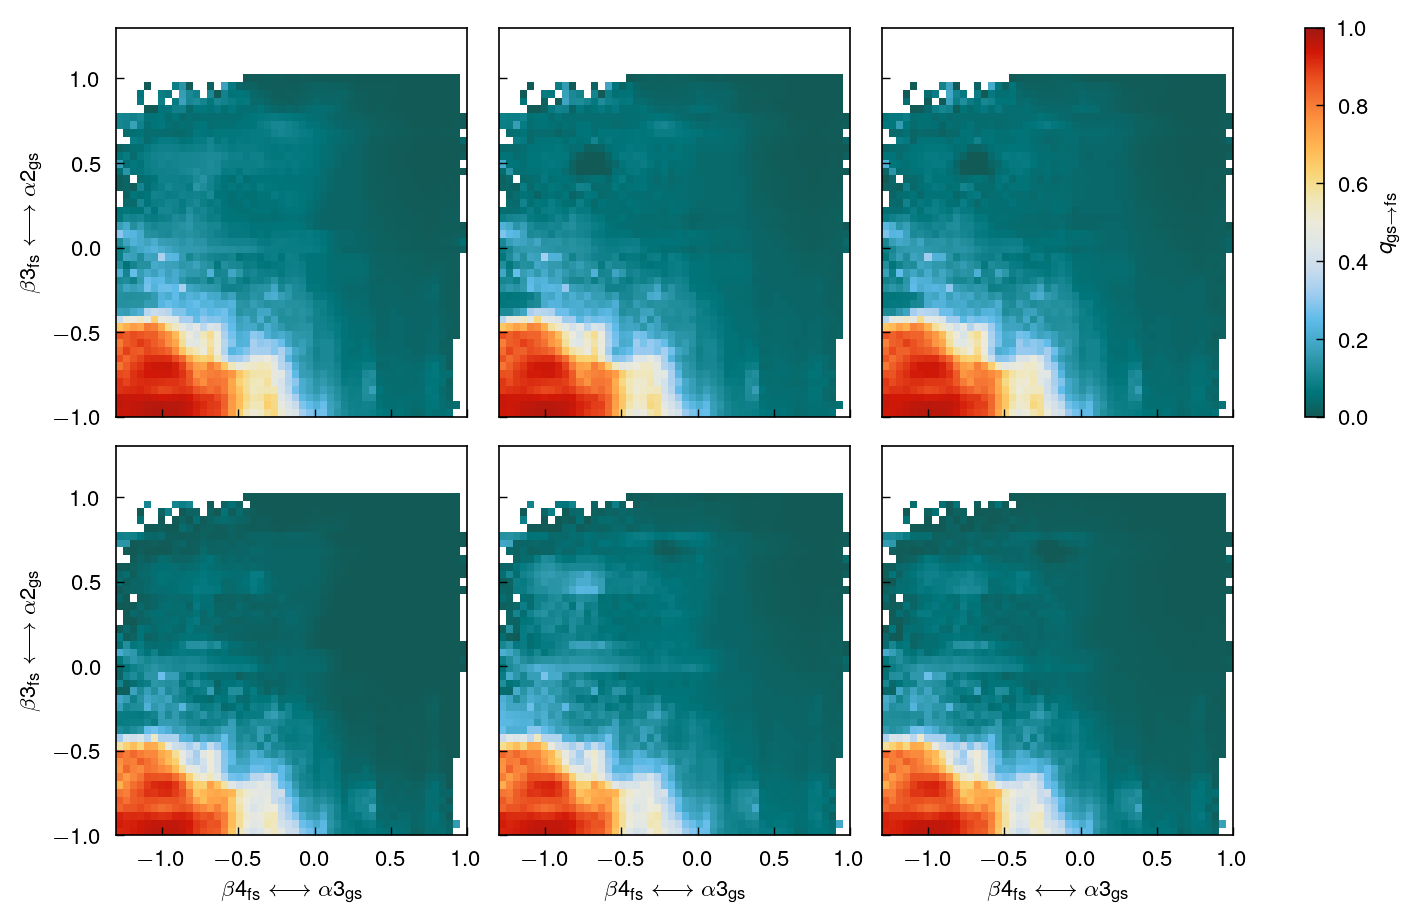

In [32]:
# plot against "GT" and "OT"
fig, axes = plt.subplots(
    nrows=2, ncols=3, figsize=(7, 4.5), dpi=200, sharex=True, sharey=True, constrained_layout=True
)

xe = np.linspace(-1.3, 1, 51)
ye = np.linspace(-1, 1.3, 51)
xc = (xe[1:] + xe[:-1]) / 2
yc = (ye[1:] + ye[:-1]) / 2
clines = np.arange(0, 12, 2)

for i in range(2):
    lag = lags[i + 3]
    w = weights[i + 3]
    for j in range(3):
        ax = axes[i, j]
        q = qp_fs2gs[(lag, mems[j])]
        hist = extq.projection.average2d(c_green, c_orange, q, w, xe, ye)
        pc = ax.pcolormesh(xc, yc, hist.T, cmap="nightfall", vmin=0, vmax=1)
        # ax.contour(xc, yc, hist.T, colors="black", levels=clines)
        ax.set_xlabel(r"$\beta4_{\mathrm{fs}}\longleftrightarrow\alpha3_{\mathrm{gs}}$")
        ax.set_ylabel(
            r"$\beta3_{\mathrm{fs}}\longleftrightarrow\alpha2_{\mathrm{gs}}$",
        )
        ax.label_outer()
cb = plt.colorbar(pc, ax=axes[0, :], location="right", label=r"$q_{\mathrm{gs}\rightarrow\mathrm{fs}}$")

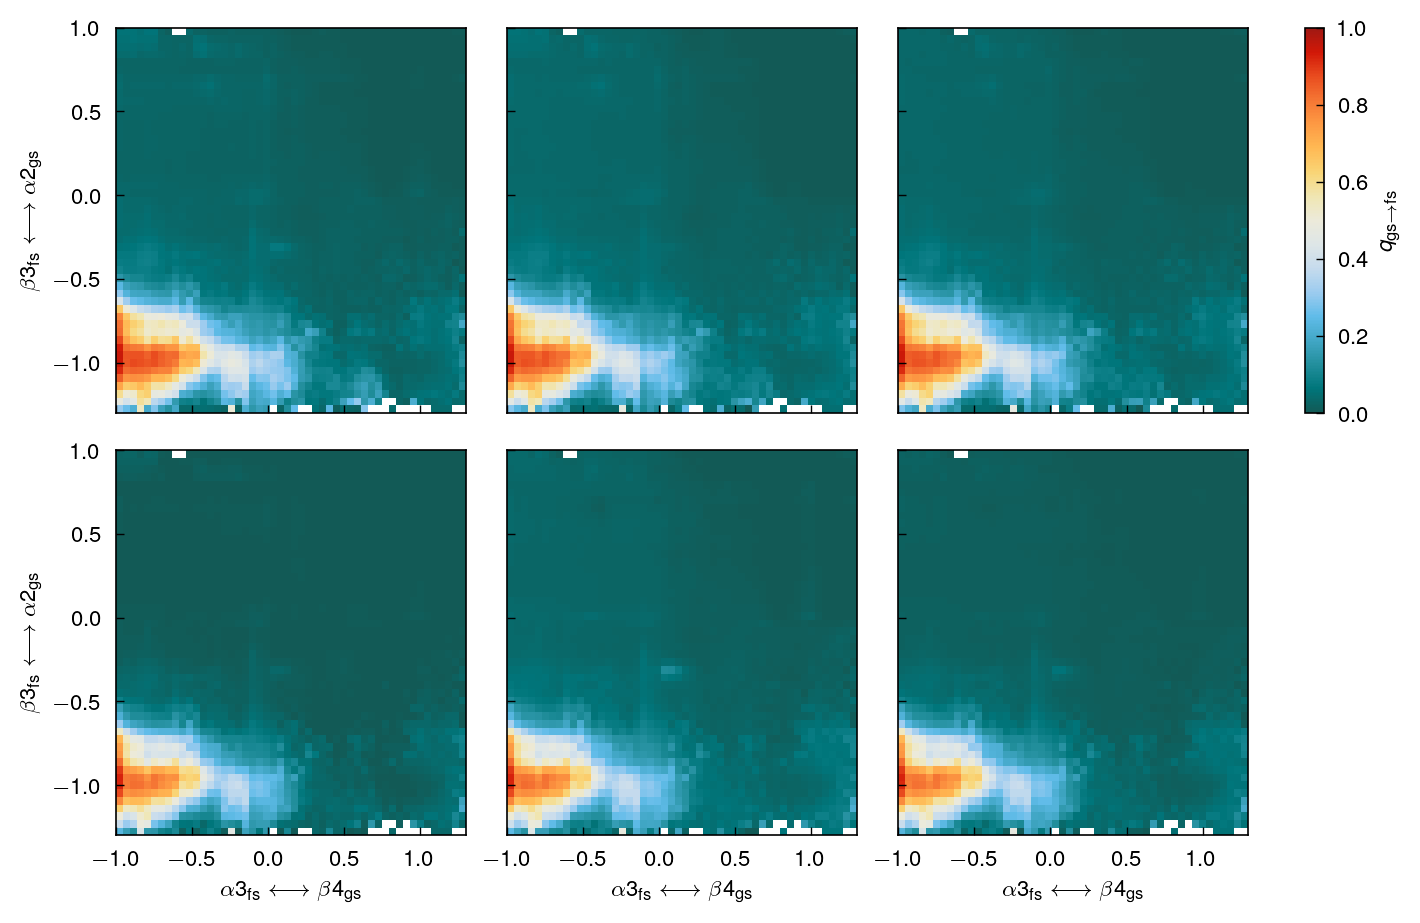

In [33]:
# plot against "GT" and "OT"
fig, axes = plt.subplots(
    nrows=2, ncols=3, figsize=(7, 4.5), dpi=200, sharex=True, sharey=True, constrained_layout=True
)

xe = np.linspace(-1, 1.3, 51)
ye = np.linspace(-1.3, 1, 51)
xc = (xe[1:] + xe[:-1]) / 2
yc = (ye[1:] + ye[:-1]) / 2
clines = np.arange(0, 12, 2)

for i in range(2):
    lag = lags[i + 3]
    w = weights[i + 3]
    for j in range(3):
        ax = axes[i, j]
        q = qp_fs2gs[(lag, mems[j])]
        hist = extq.projection.average2d(c_blue, c_orange, q, w, xe, ye)
        pc = ax.pcolormesh(xc, yc, hist.T, cmap="nightfall", vmin=0, vmax=1)
        # ax.contour(xc, yc, hist.T, colors="black", levels=clines)
        ax.set_ylabel(r"$\beta3_{\mathrm{fs}}\longleftrightarrow\alpha2_{\mathrm{gs}}$")
        ax.set_xlabel(
            r"$\alpha3_{\mathrm{fs}}\longleftrightarrow\beta4_{\mathrm{gs}}$",
        )
        ax.label_outer()
cb = plt.colorbar(pc, ax=axes[0, :], location="right", label=r"$q_{\mathrm{gs}\rightarrow\mathrm{fs}}$")

In [23]:
lag = 2000
names = ["blue", "green", "orange", "r_rmsd", "qp"]
labels = dict(
    blue=r"$\alpha3_{\mathrm{fs}}\longleftrightarrow \beta4_{\mathrm{gs}}$",
    green=r"$\beta4_{\mathrm{fs}}\longleftrightarrow\alpha3_{\mathrm{gs}}$",
    orange=r"$\beta3_{\mathrm{fs}}\longleftrightarrow\alpha2_{\mathrm{gs}}$",
    r_rmsd=r"core RMSD (nm)",
    qp=r"$q_{\mathrm{gs}\rightarrow\mathrm{fs}}$",
)
lims = dict(blue=(-1, 1.3), green=(-1.3, 1), orange=(-1.3, 1), r_rmsd=(0, 1.5), qp=(0, 1))

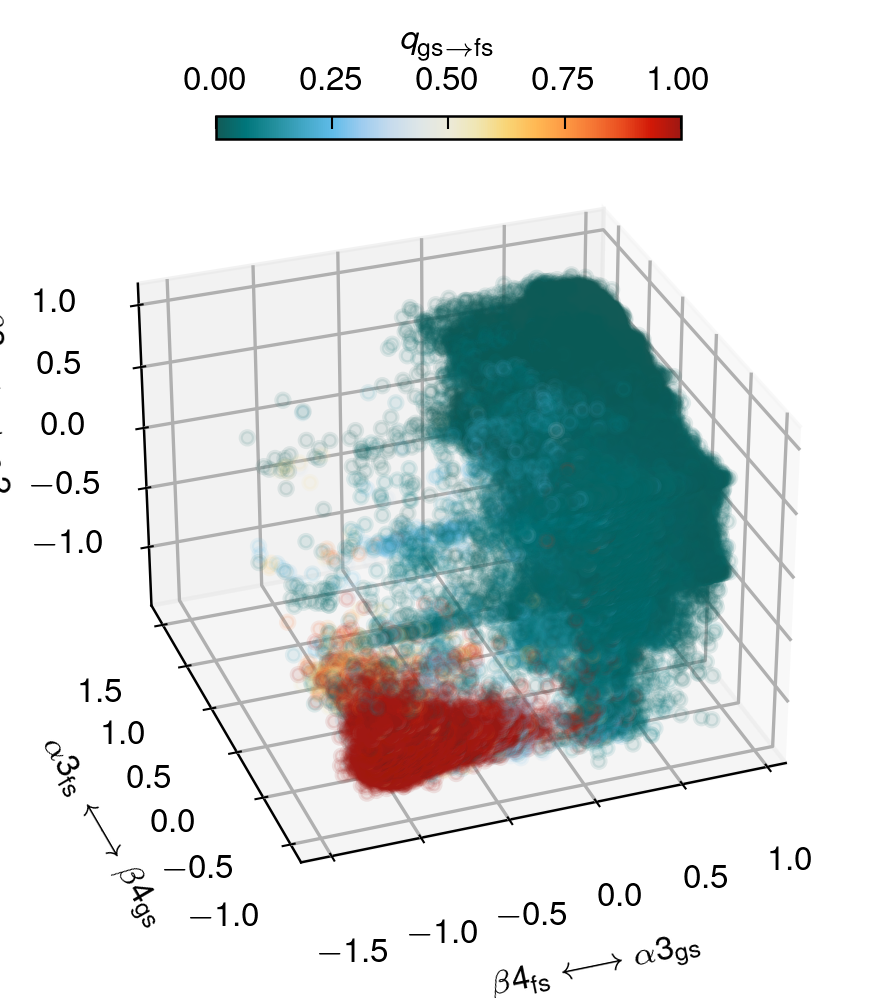

In [35]:
fig = plt.figure(figsize=(4, 4), dpi=300)
q_arr = np.ravel(qp_gs2fs)
N = len(q_arr)
skip = 200
sc_ind = np.random.choice(N, N // skip)

ax = fig.add_subplot(projection="3d")
sc = ax.scatter(
    c_green_arr[sc_ind],
    c_blue_arr[sc_ind],
    c_orange_arr[sc_ind],
    "o",
    c=q_arr[sc_ind],
    cmap="nightfall",
    alpha=0.1,
    s=10,
    rasterized=True,
    vmin=0,
    vmax=1,
)
ax.set_xlabel(labels["green"])
ax.set_ylabel(labels["blue"])
ax.set_zlabel(labels["orange"])
ax.grid(True)
cb = plt.colorbar(sc, ax=ax, shrink=0.5, location="top", pad=0, label=labels["qp"])
cb.solids.set(alpha=1)
ax.view_init(elev=30, azim=-110)

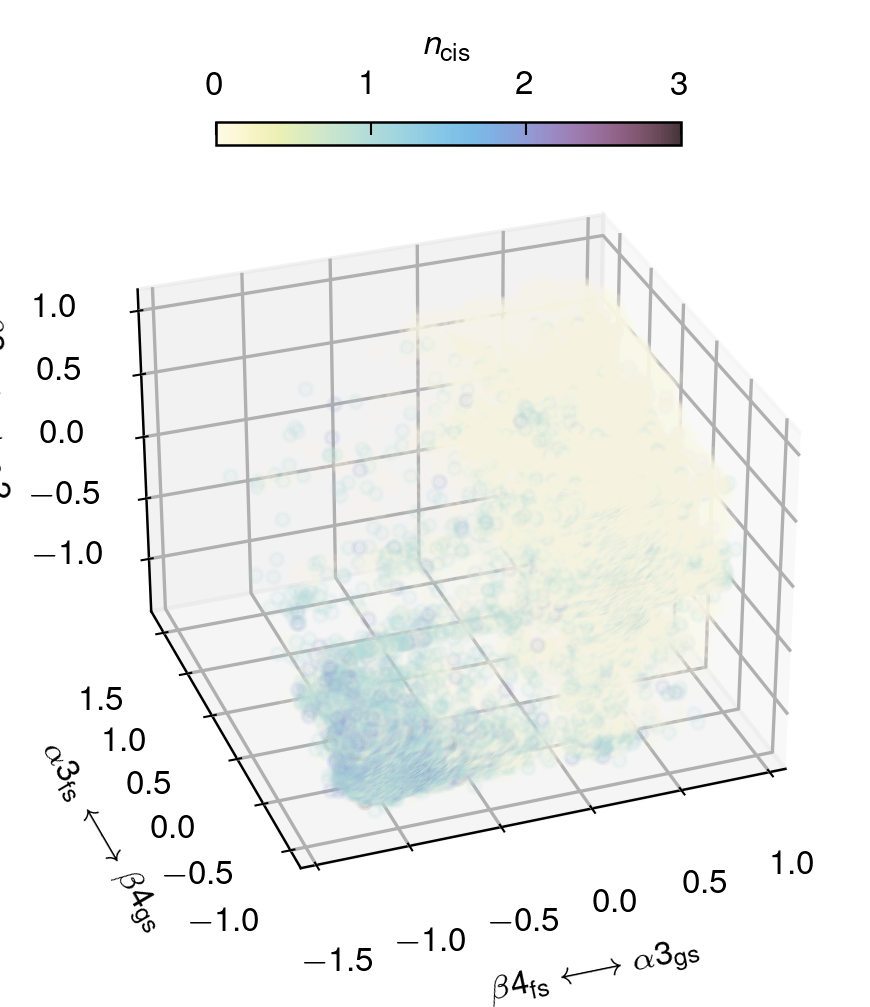

In [36]:
fig = plt.figure(figsize=(4, 4), dpi=300)
q_arr = np.ravel(qp_gs2fs)
N = len(q_arr)
skip = 200
sc_ind = np.random.choice(N, N // skip)

ax = fig.add_subplot(projection="3d")
sc = ax.scatter(
    c_green_arr[sc_ind],
    c_blue_arr[sc_ind],
    c_orange_arr[sc_ind],
    "o",
    c=np.ravel(n_cis)[sc_ind],
    cmap="iridescent",
    alpha=0.1,
    s=10,
    rasterized=True,
    vmin=0,
    vmax=3,
)
ax.set_xlabel(labels["green"])
ax.set_ylabel(labels["blue"])
ax.set_zlabel(labels["orange"])
ax.grid(True)
cb = plt.colorbar(sc, ax=ax, shrink=0.5, location="top", pad=0, label=r"$n_{\text{cis}}$")
cb.solids.set(alpha=1)
ax.view_init(elev=30, azim=-110)

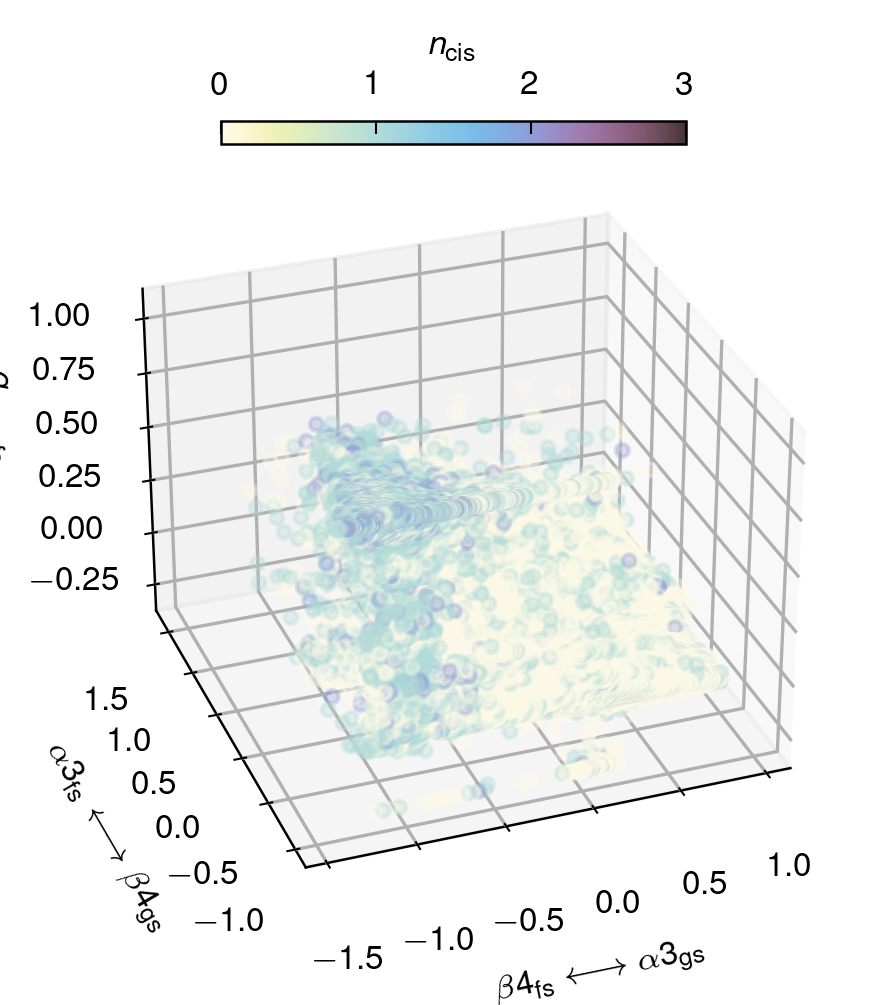

In [37]:
fig = plt.figure(figsize=(4, 4), dpi=300)
q_arr = np.ravel(qp_gs2fs)
N = len(q_arr)
skip = 200
sc_ind = np.random.choice(N, N // skip)

ax = fig.add_subplot(projection="3d")
sc = ax.scatter(
    c_green_arr[sc_ind],
    c_blue_arr[sc_ind],
    q_arr[sc_ind],
    "o",
    c=np.ravel(n_cis)[sc_ind],
    cmap="iridescent",
    alpha=0.3,
    s=10,
    rasterized=True,
    vmin=0,
    vmax=3,
)
ax.set_xlabel(labels["green"])
ax.set_ylabel(labels["blue"])
ax.set_zlabel(labels["qp"])
ax.grid(True)
cb = plt.colorbar(sc, ax=ax, shrink=0.5, location="top", pad=0, label=r"$n_{\text{cis}}$")
cb.solids.set(alpha=1)
ax.view_init(elev=30, azim=-110)

# Plot averages over committor

(array([0.000000e+00, 0.000000e+00, 0.000000e+00, 5.600000e+01,
        3.574000e+03, 2.974200e+04, 9.392300e+04, 1.784010e+05,
        2.615070e+05, 3.418080e+05, 4.623140e+05, 7.188060e+05,
        1.016790e+06, 1.189181e+06, 1.422148e+06, 1.742189e+06,
        2.110720e+06, 2.323949e+06, 2.121006e+06, 1.630417e+06,
        1.215022e+06, 1.050370e+06, 1.115300e+06, 1.231163e+06,
        1.132781e+06, 9.166790e+05, 7.155080e+05, 5.840730e+05,
        5.122090e+05, 4.636610e+05, 4.294440e+05, 4.159210e+05,
        3.973010e+05, 3.497170e+05, 3.134660e+05, 3.117600e+05,
        3.355130e+05, 3.493570e+05, 3.413570e+05, 3.275090e+05,
        3.179000e+05, 3.154570e+05, 3.171440e+05, 3.161080e+05,
        3.138460e+05, 3.122400e+05, 3.113400e+05, 3.135880e+05,
        3.144200e+05, 3.123380e+05, 3.089750e+05, 2.994140e+05,
        2.893530e+05, 2.770220e+05, 2.669880e+05, 2.585630e+05,
        2.483210e+05, 2.281830e+05, 2.040130e+05, 1.855270e+05,
        1.692350e+05, 1.564490e+05, 1.42

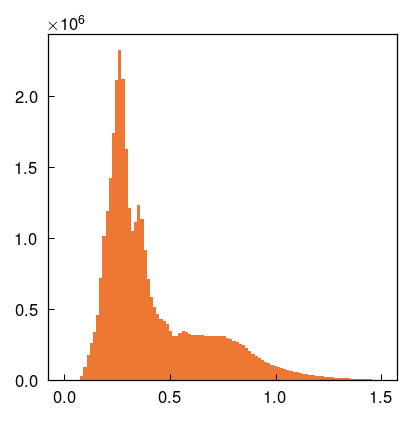

In [33]:
r_rmsds_arr = np.ravel(r_rmsds)
plt.hist(r_rmsds_arr, bins=100, range=[0, 1.5])

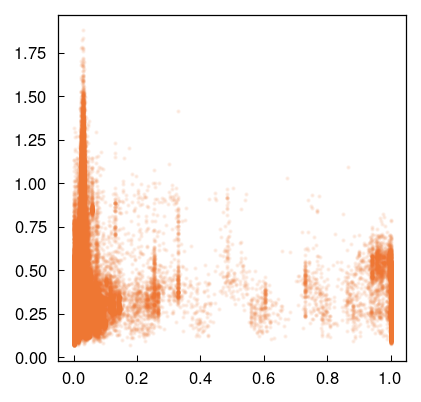

In [38]:
plt.plot(q_arr.clip(min=0, max=1)[sc_ind], r_rmsds_arr[sc_ind], ".", alpha=0.1)

(0.0, 0.2)

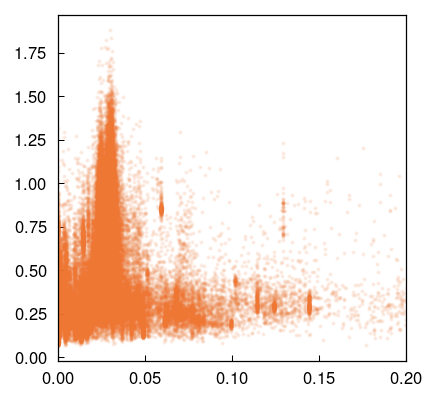

In [39]:
plt.plot(q_arr.clip(min=0, max=1)[sc_ind], r_rmsds_arr[sc_ind], ".", alpha=0.1)
plt.xlim([0, 0.2])

/scratch/local/jobs/10844175/ipykernel_85736/3050398761.py:4: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(dens)


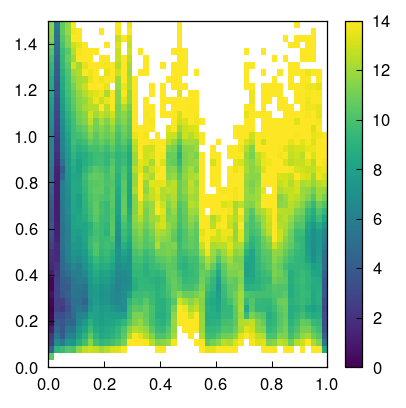

In [58]:
xe = np.linspace(0, 1, 51)
ye = np.linspace(0, 1.5, 51)
dens = extq.projection.density2d(qp_fs2gs[(1000, 4)], r_rmsds, weights[4], xe, ye)
pmf = -np.log(dens)
pmf -= np.min(pmf)
plt.pcolormesh(xe, ye, pmf.T, vmax=14)
plt.colorbar()

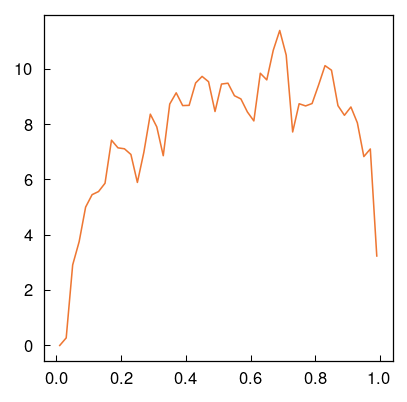

In [40]:
xe = np.linspace(0, 1, 51)
xc = (xe[1:] + xe[:-1]) / 2
dens = extq.projection.density1d(qp_gs2fs, weights[4], xe)
pmf = -np.log(dens)
plt.plot(xc, pmf - np.min(pmf))

In [42]:
def bin_inds(q, qstep=0.05, low=0, hi=1):
    q_arr = np.concatenate(q)
    nsteps = round((hi - low) / qstep)
    all_inds = []
    steps = np.linspace(low, hi - qstep, nsteps)
    for i, s in enumerate(steps):
        q_inds = ((q_arr >= s) & (q_arr <= s + qstep)).nonzero()[0]
        all_inds.append(q_inds)
    return steps, all_inds

In [67]:
steps, q_inds = bin_inds(qp_gs2fs, qstep=0.1, low=0, hi=1)

In [68]:
steplabels = []
for i, s in enumerate(steps):
    if i % 2 == 0:
        steplabels.append(f"{s+0.05:.2f}")
    else:
        steplabels.append("")

(-1.0, 10.0)

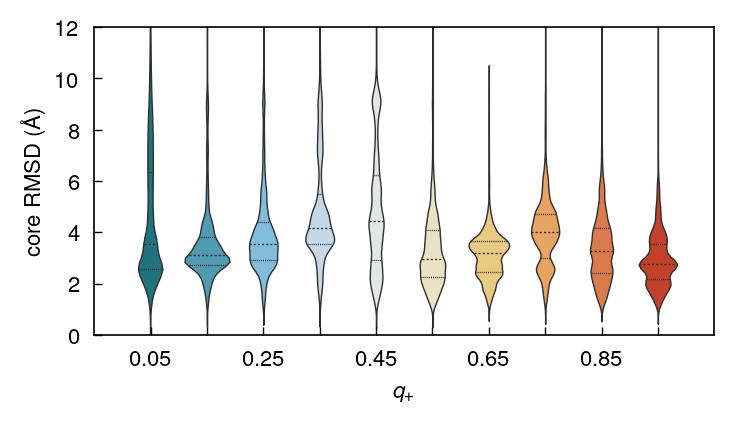

In [70]:
f = plt.figure(figsize=(4, 2), dpi=200)
ax0 = plt.gca()
sns.violinplot(
    ax=ax0,
    data=[r_rmsds_arr[inds] * 10 for inds in q_inds],
    scale="area",
    bw=0.1,
    inner="quartile",
    palette="nightfall",
    orient="v",
    linewidth=0.5,
)

ax0.set_xticklabels(steplabels)
ax0.set_xlabel("$q_+$")
ax0.set_ylabel("core RMSD (Å)")
ax0.set_ylim([0, 12])
ax0.set_xlim([-1, 10])

In [60]:
print("gs state")
n_cis_slice = np.ravel(n_cis)[in_gs]
N = len(n_cis_slice)
for i in range(5):
    print(f"\tFraction n cis = {i}: {np.count_nonzero(n_cis_slice == i) / N * 100:.1f}%")

for step, inds in zip(steps, q_inds):
    n_cis_slice = np.ravel(n_cis)[inds]
    N = len(n_cis_slice)
    print(f"q+ = [{step:.1f}, {step+0.1:.1f}]")
    for i in range(5):
        print(f"\tFraction n cis = {i}: {np.count_nonzero(n_cis_slice == i) / N * 100:.1f}%")

print("fs state")
n_cis_slice = np.ravel(n_cis)[in_fs]
N = len(n_cis_slice)
for i in range(5):
    print(f"\tFraction n cis = {i}: {np.count_nonzero(n_cis_slice == i) / N * 100:.1f}%")

gs state
	Fraction n cis = 0: 99.9%
	Fraction n cis = 1: 0.1%
	Fraction n cis = 2: 0.0%
	Fraction n cis = 3: 0.0%
	Fraction n cis = 4: 0.0%
q+ = [0.0, 0.1]
	Fraction n cis = 0: 93.3%
	Fraction n cis = 1: 6.5%
	Fraction n cis = 2: 0.1%
	Fraction n cis = 3: 0.0%
	Fraction n cis = 4: 0.0%
q+ = [0.1, 0.2]
	Fraction n cis = 0: 78.0%
	Fraction n cis = 1: 20.7%
	Fraction n cis = 2: 1.2%
	Fraction n cis = 3: 0.0%
	Fraction n cis = 4: 0.0%
q+ = [0.2, 0.3]
	Fraction n cis = 0: 65.5%
	Fraction n cis = 1: 31.9%
	Fraction n cis = 2: 2.5%
	Fraction n cis = 3: 0.0%
	Fraction n cis = 4: 0.0%
q+ = [0.3, 0.4]
	Fraction n cis = 0: 75.3%
	Fraction n cis = 1: 22.7%
	Fraction n cis = 2: 1.9%
	Fraction n cis = 3: 0.0%
	Fraction n cis = 4: 0.0%
q+ = [0.4, 0.5]
	Fraction n cis = 0: 46.6%
	Fraction n cis = 1: 49.3%
	Fraction n cis = 2: 4.1%
	Fraction n cis = 3: 0.0%
	Fraction n cis = 4: 0.0%
q+ = [0.5, 0.6]
	Fraction n cis = 0: 47.1%
	Fraction n cis = 1: 44.3%
	Fraction n cis = 2: 8.5%
	Fraction n cis = 3: 0.1%

In [61]:
def compute_per_res_prob_ss(dssp):
    total = len(dssp)
    prob_helix = np.count_nonzero(dssp == 0, axis=0) / total
    prob_strand = np.count_nonzero(dssp == 1, axis=0) / total
    prob_coil = np.count_nonzero(dssp == 2, axis=0) / total
    assert np.allclose(prob_helix + prob_strand + prob_coil, 1)
    return prob_helix, prob_strand, prob_coil

Text(0, 0.5, 'Probability\n$\\beta$-strand$\\qquad$$\\alpha$-helix')

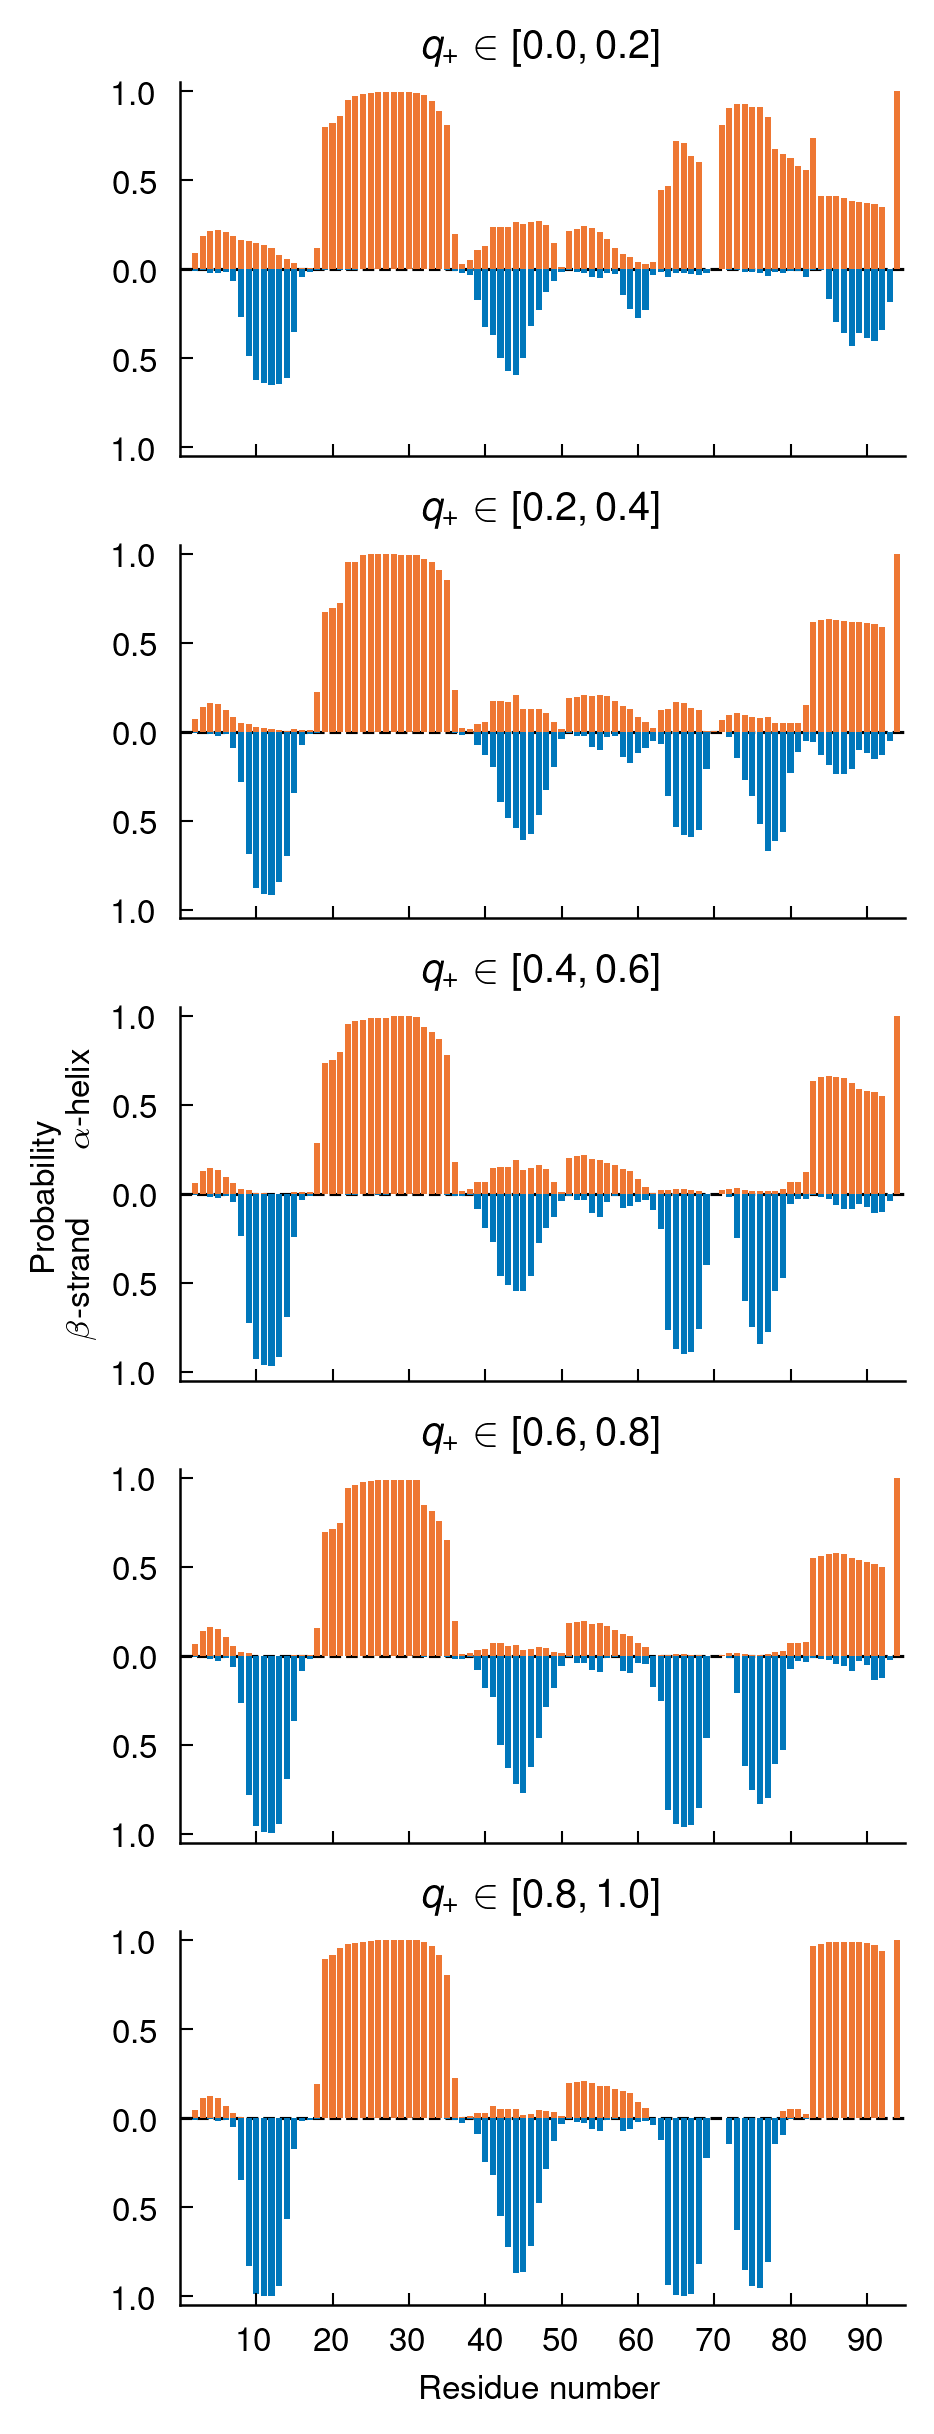

In [65]:
steps, q_inds = bin_inds(qp_gs2fs, qstep=0.2, low=0, hi=1)
dssp_arr = np.concatenate(dssps)

fig, axes = plt.subplots(
    nrows=5, figsize=(3, 8), dpi=300, sharex=True, sharey=True, constrained_layout=True
)
for ax, step, inds in zip(axes.flat, steps, q_inds):
    prob_helix, prob_strand, prob_coil = compute_per_res_prob_ss(dssp_arr[inds])
    ax.bar(range(len(prob_coil)), prob_helix, color="C0", align="center")
    ax.bar(range(len(prob_coil)), -prob_strand, color="C1", align="center")
    ax.set_xlim([-1, len(prob_coil)])
    ax.set_ylim([-1.05, 1.05])
    ax.set_title(f"$q_+ \\in [{step:.1f}, {step + 0.2:.1f}]$")
    ax.set_xlabel("Residue number")
    ax.set_xticks(np.arange(9, 99, 10), labels=np.arange(10, 100, 10))
    ax.set_yticks(np.linspace(-1, 1, 5), labels=[1.0, 0.5, 0.0, 0.5, 1.0])

    ax.axhline(0, ls="--", color="k", zorder=0)
    sns.despine(ax=ax, top=True, right=True, bottom=False, left=False)
    ax.label_outer()
axes[2].set_ylabel("Probability\n$\\beta$-strand$\qquad$$\\alpha$-helix")

In [66]:
import sklearn.cluster

In [ ]:
sklearn.cluster.AgglomerativeClustering(

# Proline states

In [130]:
from collections import OrderedDict
from itertools import product

In [131]:
p63_cis_arr = np.ravel(p63_cis)
p70_cis_arr = np.ravel(p70_cis)
p71_cis_arr = np.ravel(p71_cis)
p72_cis_arr = np.ravel(p72_cis)

# assign proline states
dtraj = np.zeros_like(p63_cis_arr, dtype=int)
state_dict = OrderedDict()
fn_seq_iterator = product([lambda x: x, np.logical_not], repeat=4)
for i, (state, fn_seq) in enumerate(zip(product("CT", repeat=4), fn_seq_iterator)):
    # fn_seq is something like (Identity, ~, Identity, ~)
    seq = fn_seq[0](p63_cis_arr) & fn_seq[1](p70_cis_arr) & fn_seq[2](p71_cis_arr) & fn_seq[3](p72_cis_arr)
    state_name = "".join(state)
    print(f"{state_name}: {np.count_nonzero(seq) / len(seq) * 100:6.3f}%")
    state_dict[state_name] = i
    dtraj[seq] = i

CCCC:  0.000%
CCCT:  0.026%
CCTC:  0.014%
CCTT:  0.818%
CTCC:  0.001%
CTCT:  1.152%
CTTC:  0.095%
CTTT:  5.276%
TCCC:  0.000%
TCCT:  0.121%
TCTC:  0.072%
TCTT:  4.003%
TTCC:  0.006%
TTCT:  5.376%
TTTC:  0.592%
TTTT: 82.450%


In [132]:
print(state_dict)

OrderedDict([('CCCC', 0), ('CCCT', 1), ('CCTC', 2), ('CCTT', 3), ('CTCC', 4), ('CTCT', 5), ('CTTC', 6), ('CTTT', 7), ('TCCC', 8), ('TCCT', 9), ('TCTC', 10), ('TCTT', 11), ('TTCC', 12), ('TTCT', 13), ('TTTC', 14), ('TTTT', 15)])


In [103]:
dtraj

array([15, 15, 15, ..., 15, 15, 15])

In [107]:
def make_basis(dtraj, traj_lens):
    basis_arr = make_sparse_basis(dtraj)
    basis = []
    curr = 0
    for t_len in traj_lens:
        basis.append(basis_arr[curr : curr + t_len])
        curr += t_len
    return basis


def compute_transition_matrix(basis, weights, lag):
    C0 = 0.0
    Ct = 0.0
    test_basis = basis
    for w, x, y in zip(weights, basis, test_basis):
        wx = scipy.sparse.diags(w) @ x
        C0 += wx[:-lag].T @ y[:-lag]
        Ct += wx[:-lag].T @ y[lag:]
    return scipy.sparse.linalg.inv(C0) @ Ct

In [119]:
traj_lens = [len(traj) for traj in raw_feats]
basis = make_basis(dtraj, traj_lens)
t_mats = []
for w, lag in zip(weights, lags):
    t_mats.append(compute_transition_matrix(basis, w, lag))

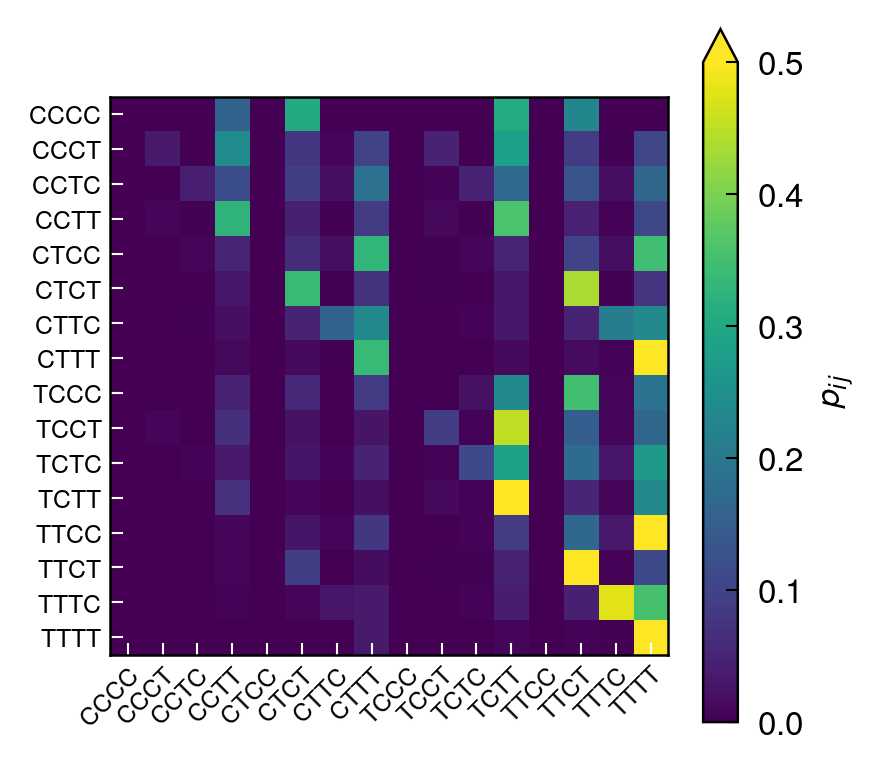

In [141]:
f = plt.figure(dpi=300)
plt.imshow(t_mats[0].A, vmin=0, vmax=0.5)
plt.colorbar(label=r"$p_{ij}$", extend="max")
ax = plt.gca()
ax.set_yticks(np.arange(16), state_dict.keys(), fontsize=6, fontfamily="monospace")
ax.set_xticks(
    np.arange(16),
    state_dict.keys(),
    ha="right",
    rotation_mode="anchor",
    rotation=45,
    fontsize=6,
    fontfamily="monospace",
)
ax.tick_params(color="white", pad=2)

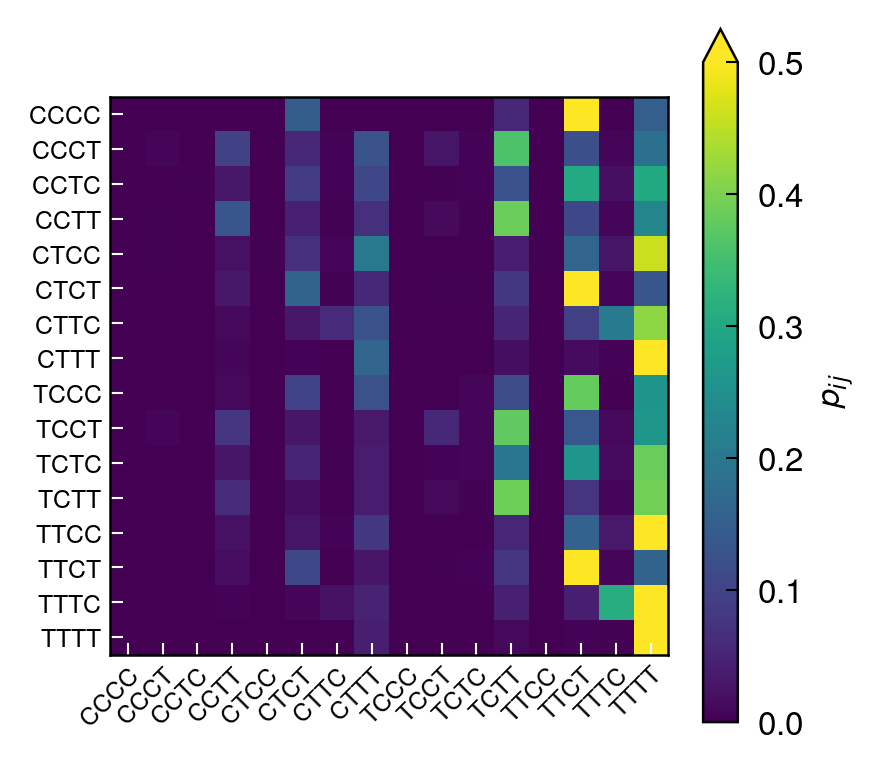

In [142]:
f = plt.figure(dpi=300)
plt.imshow(t_mats[2].A, vmin=0, vmax=0.5)
plt.colorbar(label=r"$p_{ij}$", extend="max")
ax = plt.gca()
ax.set_yticks(np.arange(16), state_dict.keys(), fontsize=6, fontfamily="monospace")
ax.set_xticks(
    np.arange(16),
    state_dict.keys(),
    ha="right",
    rotation_mode="anchor",
    rotation=45,
    fontsize=6,
    fontfamily="monospace",
)
ax.tick_params(color="white", pad=2)

In [176]:
from itertools import combinations

In [184]:
def cis_transitions(tmat, rev=False):
    for ids in combinations(range(4), 2):
        single_cis_0, single_cis_1, double_cis = ['T', 'T', 'T', 'T'], ['T', 'T', 'T', 'T'], ['T', 'T', 'T', 'T'] 
        single_cis_0[ids[0]] = 'C'
        single_cis_1[ids[1]] = 'C'
        double_cis[ids[0]] = 'C'
        double_cis[ids[1]] = 'C'
        single_cis_0 = "".join(single_cis_0)
        single_cis_1 = "".join(single_cis_1)
        double_cis = "".join(double_cis)
        
        print(f"State 1: {single_cis_0}\tState 2: {single_cis_1}")

        if rev:
            tmat = tmat.T
        p0 = tmat[state_dict[single_cis_0], state_dict['TTTT']] 
        p1 = tmat[state_dict[single_cis_1], state_dict['TTTT']]
        p_joint = tmat[state_dict[double_cis], state_dict['TTTT']]
        print(f"\tState 1->TTTT: {p0:4>.3e}")
        print(f"\tState 2->TTTT: {p1:4>.3e}")
        print(f"\tProduct:       {p0 * p1:4>.3e}")
        print(f"\tJoint  ->TTTT: {p_joint:4>.3e}")
        print(f"\tjoint/product: {p_joint / (p0 * p1):4>.3f}")

In [178]:
cis_transitions(t_mats[2])

State 1: CTTT	State 2: TCTT
	State 1->TTTT: 7.842e-01
	State 2->TTTT: 3.926e-01
	Product:       3.079e-01
	Joint  ->TTTT: 2.281e-01
	joint/product: 0.741
State 1: CTTT	State 2: TTCT
	State 1->TTTT: 7.842e-01
	State 2->TTTT: 1.601e-01
	Product:       1.256e-01
	Joint  ->TTTT: 1.335e-01
	joint/product: 1.063
State 1: CTTT	State 2: TTTC
	State 1->TTTT: 7.842e-01
	State 2->TTTT: 5.138e-01
	Product:       4.029e-01
	Joint  ->TTTT: 4.151e-01
	joint/product: 1.030
State 1: TCTT	State 2: TTCT
	State 1->TTTT: 3.926e-01
	State 2->TTTT: 1.601e-01
	Product:       6.287e-02
	Joint  ->TTTT: 2.642e-01
	joint/product: 4.202
State 1: TCTT	State 2: TTTC
	State 1->TTTT: 3.926e-01
	State 2->TTTT: 5.138e-01
	Product:       2.017e-01
	Joint  ->TTTT: 3.868e-01
	joint/product: 1.917
State 1: TTCT	State 2: TTTC
	State 1->TTTT: 1.601e-01
	State 2->TTTT: 5.138e-01
	Product:       8.227e-02
	Joint  ->TTTT: 6.156e-01
	joint/product: 7.482


In [187]:
cis_transitions(t_mats[3])
print(reversed)
cis_transitions(t_mats[3], rev=True)

State 1: CTTT	State 2: TCTT
	State 1->TTTT: 8.400e-01
	State 2->TTTT: 4.842e-01
	Product:       4.068e-01
	Joint  ->TTTT: 2.815e-01
	joint/product: 0.692
State 1: CTTT	State 2: TTCT
	State 1->TTTT: 8.400e-01
	State 2->TTTT: 2.003e-01
	Product:       1.682e-01
	Joint  ->TTTT: 1.585e-01
	joint/product: 0.942
State 1: CTTT	State 2: TTTC
	State 1->TTTT: 8.400e-01
	State 2->TTTT: 6.415e-01
	Product:       5.389e-01
	Joint  ->TTTT: 5.077e-01
	joint/product: 0.942
State 1: TCTT	State 2: TTCT
	State 1->TTTT: 4.842e-01
	State 2->TTTT: 2.003e-01
	Product:       9.698e-02
	Joint  ->TTTT: 3.316e-01
	joint/product: 3.419
State 1: TCTT	State 2: TTTC
	State 1->TTTT: 4.842e-01
	State 2->TTTT: 6.415e-01
	Product:       3.107e-01
	Joint  ->TTTT: 3.801e-01
	joint/product: 1.224
State 1: TTCT	State 2: TTTC
	State 1->TTTT: 2.003e-01
	State 2->TTTT: 6.415e-01
	Product:       1.285e-01
	Joint  ->TTTT: 5.877e-01
	joint/product: 4.574
<class 'reversed'>
State 1: CTTT	State 2: TCTT
	State 1->TTTT: 4.312e-02
	St

In [154]:
# (TTCT -> TTTT) x (TTCT -> TTTT)
tmat = t_mats[2]
p1 = tmat[state_dict['TTCT'], state_dict['TTTT']] 
p2 = tmat[state_dict['TTTC'], state_dict['TTTT']]
p3 = tmat[state_dict['TTCC'], state_dict['TTTT']]
print(p1, p2, p1 * p2, p3)

0.16013147844023085 0.5137669810171287 0.08227026624404683 0.615577247558639


In [155]:
# (TTCT -> TTTT) x (TTCT -> TTTT)
tmat = t_mats[3]
p1 = tmat[state_dict['TTCT'], state_dict['TTTT']] 
p2 = tmat[state_dict['TTTC'], state_dict['TTTT']]
p3 = tmat[state_dict['TTCC'], state_dict['TTTT']]
print(p1, p2, p1 * p2, p3)

0.20026990890572136 0.6415402482660253 0.12848120707959074 0.5877336170636471


In [156]:
# (TTCC -> TTTC) x (TTTC -> TTTT)
tmat = t_mats[2]
p1 = tmat[state_dict['TTTT'], state_dict['TTCT']] 
p2 = tmat[state_dict['TTTT'], state_dict['TTTC']]
p3 = tmat[state_dict['TTTT'], state_dict['TTCC']]
print(p1, p2, p1 * p2, p3)

0.004256764214879397 0.002597050451749198 1.1055031427242358e-05 2.0888466462444494e-05


In [157]:
# (TTCC -> TTTC) x (TTTC -> TTTT)
tmat = t_mats[3]
p1 = tmat[state_dict['TTTT'], state_dict['TTCT']] 
p2 = tmat[state_dict['TTTT'], state_dict['TTTC']]
p3 = tmat[state_dict['TTTT'], state_dict['TTCC']]
print(p1, p2, p1 * p2, p3)

0.003297352999075149 0.0028111028406949037 9.269198382474011e-06 1.480445991143387e-05


In [151]:
lags

array([ 100,  200,  500, 1000, 2000, 5000])

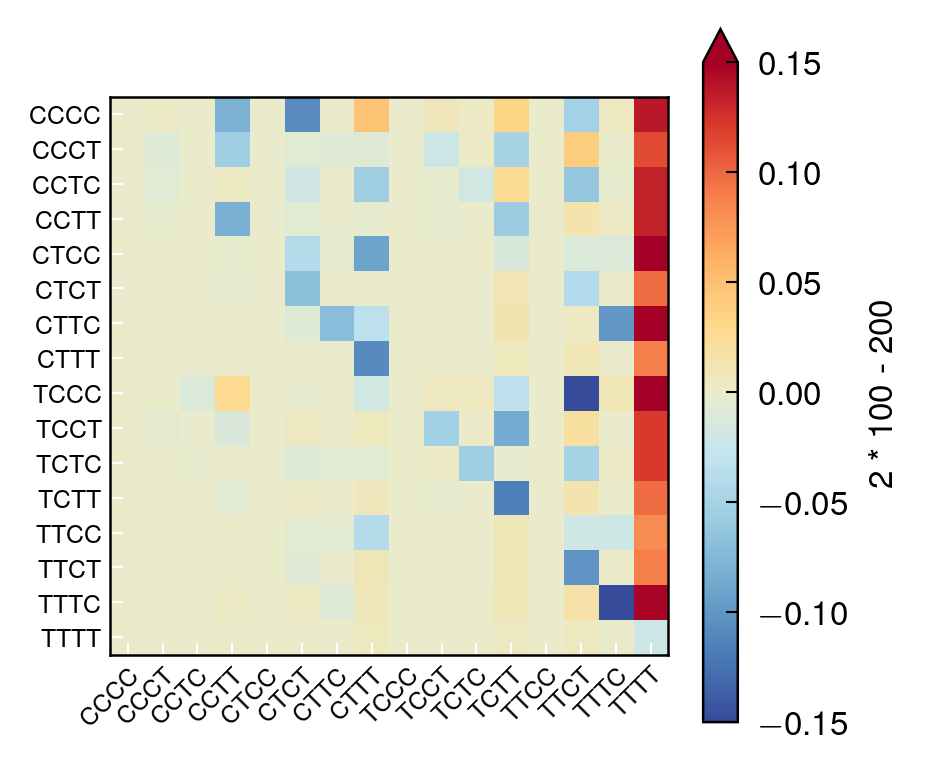

In [152]:
diff = (t_mats[0] @ t_mats[0]) - t_mats[1]
f = plt.figure(dpi=300)
plt.imshow(diff.A, vmin=-0.15, vmax=0.15, cmap='sunset')
plt.colorbar(label="2 * 100 - 200", extend="max")
ax = plt.gca()
ax.set_yticks(np.arange(16), state_dict.keys(), fontsize=6, fontfamily="monospace")
ax.set_xticks(
    np.arange(16),
    state_dict.keys(),
    ha="right",
    rotation_mode="anchor",
    rotation=45,
    fontsize=6,
    fontfamily="monospace",
)
ax.tick_params(color="white", pad=2)

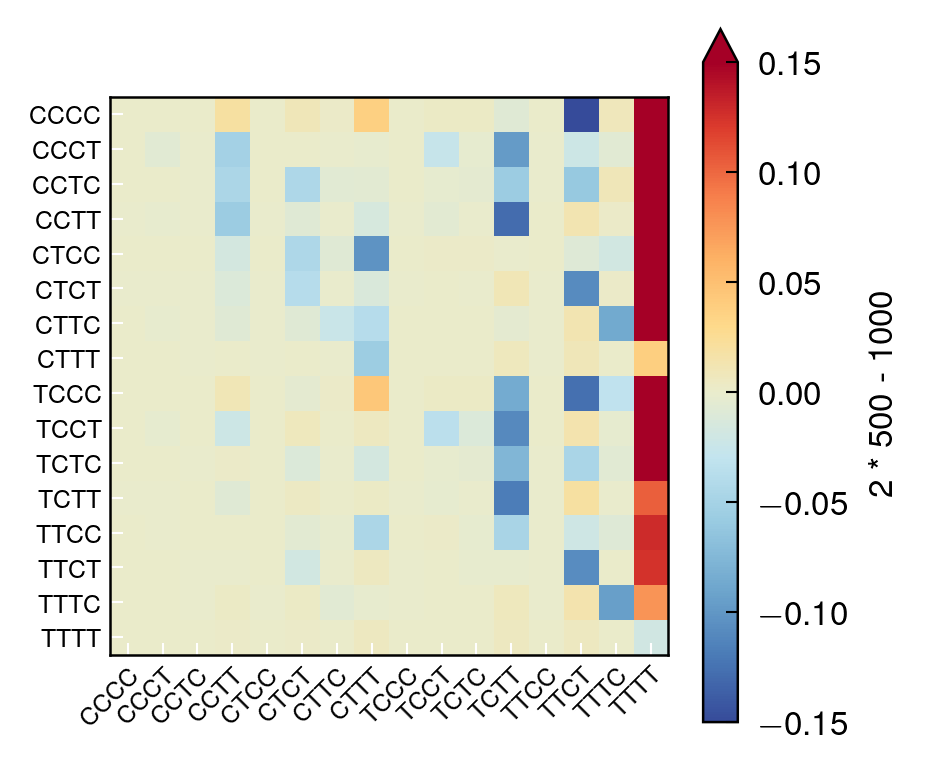

In [153]:
diff = (t_mats[2] @ t_mats[2]) - t_mats[3]
f = plt.figure(dpi=300)
plt.imshow(diff.A, vmin=-0.15, vmax=0.15, cmap='sunset')
plt.colorbar(label="2 * 500 - 1000", extend="max")
ax = plt.gca()
ax.set_yticks(np.arange(16), state_dict.keys(), fontsize=6, fontfamily="monospace")
ax.set_xticks(
    np.arange(16),
    state_dict.keys(),
    ha="right",
    rotation_mode="anchor",
    rotation=45,
    fontsize=6,
    fontfamily="monospace",
)
ax.tick_params(color="white", pad=2)

In [180]:
def compute_cis_state_frac(dtraj, weights=None):
    if weights is None:
        weights = np.ones_like(dtraj, dtype=float)
    ans = np.zeros(16, dtype=float)
    for i in range(16):
        ans[i] = np.sum(np.where(dtraj == i, weights, 0))
    return ans / np.sum(weights)

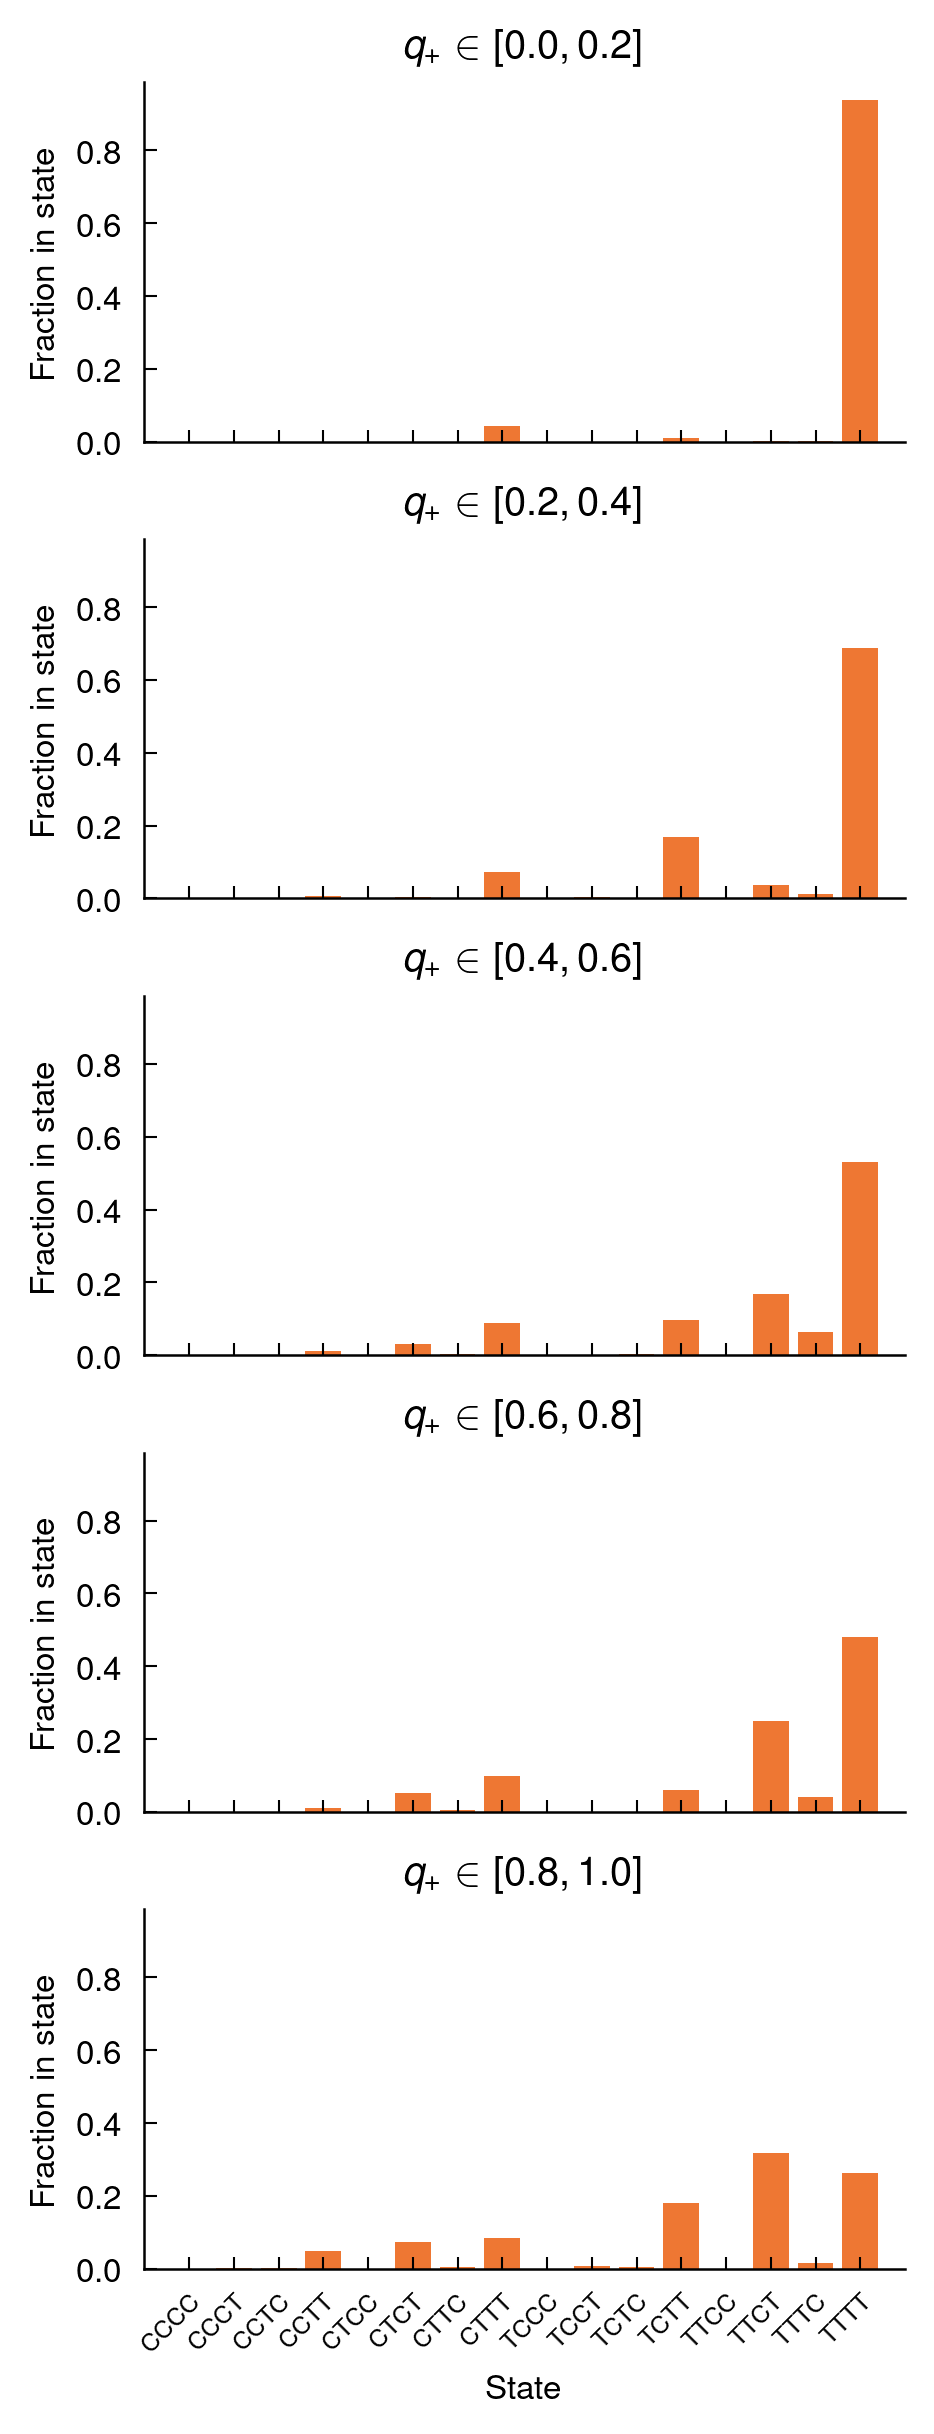

In [181]:
steps, q_inds = bin_inds(qp_gs2fs, qstep=0.2, low=0, hi=1)

fig, axes = plt.subplots(
    nrows=5, figsize=(3, 8), dpi=300, sharex=True, sharey=True, constrained_layout=True
)
for ax, step, inds in zip(axes.flat, steps, q_inds):
    fraction = compute_cis_state_frac(dtraj[inds], weights=np.ravel(weights[4])[inds])
    ax.bar(range(16), fraction, align="center")
    ax.set_xlim([-1, 16])
    ax.set_title(f"$q_+ \\in [{step:.1f}, {step + 0.2:.1f}]$")
    ax.set_xlabel("State")
    ax.set_ylabel("Fraction in state")
    sns.despine(ax=ax, top=True, right=True, bottom=False, left=False)
    ax.label_outer()

axes[-1].set_xticks(
    np.arange(16),
    state_dict.keys(),
    ha="right",
    rotation_mode="anchor",
    rotation=45,
    fontsize=6,
    fontfamily="monospace",
)